# Quantile Regresssion

In [1]:
%pip install lightning-uq-box

  Cloning https://github.com/f-dangel/curvlinops to /tmp/pip-install-l0jmlt1l/curvlinops-for-pytorch_8e3509378d424676945d614260a8c228
  Running command git clone --filter=blob:none --quiet https://github.com/f-dangel/curvlinops /tmp/pip-install-l0jmlt1l/curvlinops-for-pytorch_8e3509378d424676945d614260a8c228
  Resolved https://github.com/f-dangel/curvlinops to commit d509cd6c332cda0e3bbb7b6bd9c5f37a6aa023b1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


## Theoretic Foundation

 The goal of Quantile Regression is to extend a standard regression model to also predict conditional quantiles that approximate the true quantiles of the data at hand. It does not make assumptions about the distribution of errors as is usually common. It is a more commonly used method in Econometrics and Time-series forecasting [Koeneker, 1978](https://www.jstor.org/stable/1913643).

In the following we will describe univariate quantile regression. Any chosen conditional quantile $\alpha \in [0,1]$ can be defined as
$$
    q_\alpha(x):=\text{inf}\{y \in \mathbb{R}: F(y \vert X = x ) \geq \alpha\},
$$

where $F(y \vert X = x)=P(Y\leq y\vert X = x)$ is a strictly monotonic increasing cumulative density function.

 For Quantile Regression, the NN $f_{\theta}$ parameterized by $\theta$, is configured to output the number of quantiles that we want to predict. This means that, if we want to predict $n$ quantiles $[\alpha_1, ... \alpha_n]$,
$$
    f_{\theta}(x_{\star}) = (\hat{y}_1(x^{\star}), ...,\hat{y}_n(x^{\star})).
$$

The model is trained by minimizing the pinball loss function [Koeneker, 1978](https://www.jstor.org/stable/1913643), given by the following loss objective,

$$
    \mathcal{L}_i (\theta, (x^{\star}, y^{\star})) = \max\{ (1-\alpha_i) (y^{\star}-\hat{y}_i(x^{\star})), \alpha (y^{\star}-\hat{y}_i(x^{\star}))\}.
$$

Here $i \in \{1, ...,n\}$ denotes the number of the quantile and $100\alpha_i $ is the percentage of the quantile for $\alpha_i \in [0,1)$. Note that for $\alpha = 1/2$ one recovers the $\ell^1$ loss.

For an explanation of the pinball loss function you can checkout this [blog post](https://towardsdatascience.com/probabilistic-forecasts-pinball-loss-function-baf86a5a14d0).

During inference, the model will output an estimate for your chosen quantiles and these can be used as an indication of aleatoric uncertainty.


## Imports

In [2]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import QuantileRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [5]:
dm = ToyHeteroscedasticDatamodule()

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

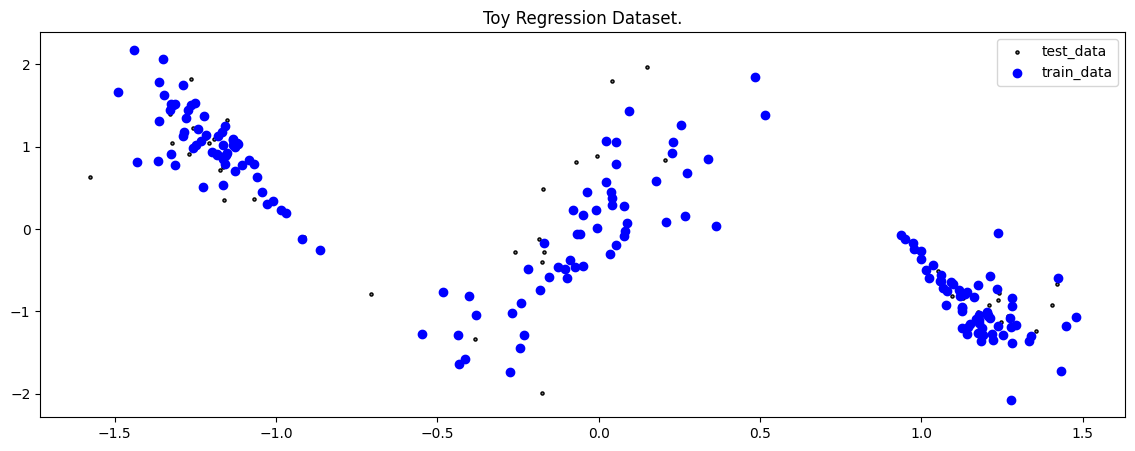

In [6]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP). For quantile regression we need a network output for each of the quantiles that we want to predict.

In [7]:
quantiles = [0.1, 0.5, 0.9]
network = MLP(
    n_inputs=1, n_hidden=[50, 50, 50], n_outputs=len(quantiles), activation_fn=nn.Tanh()
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.0, inplace=False)
    (7): Linear(in_features=50, out_features=3, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [8]:
qr_model = QuantileRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=4e-3), quantiles=quantiles
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(qr_model, dm)

Missing logger folder: /tmp/tmppzffsi3d/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.4 K 
1 | loss_fn       | PinballLoss      | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/dat

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

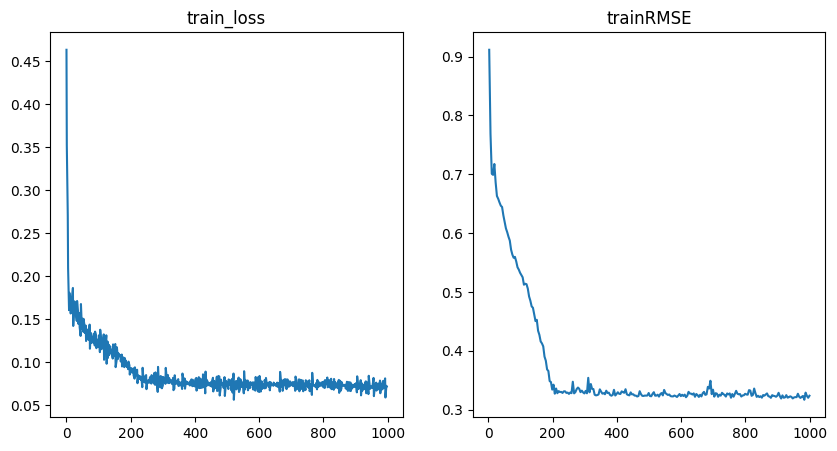

In [11]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Evaluate Predictions

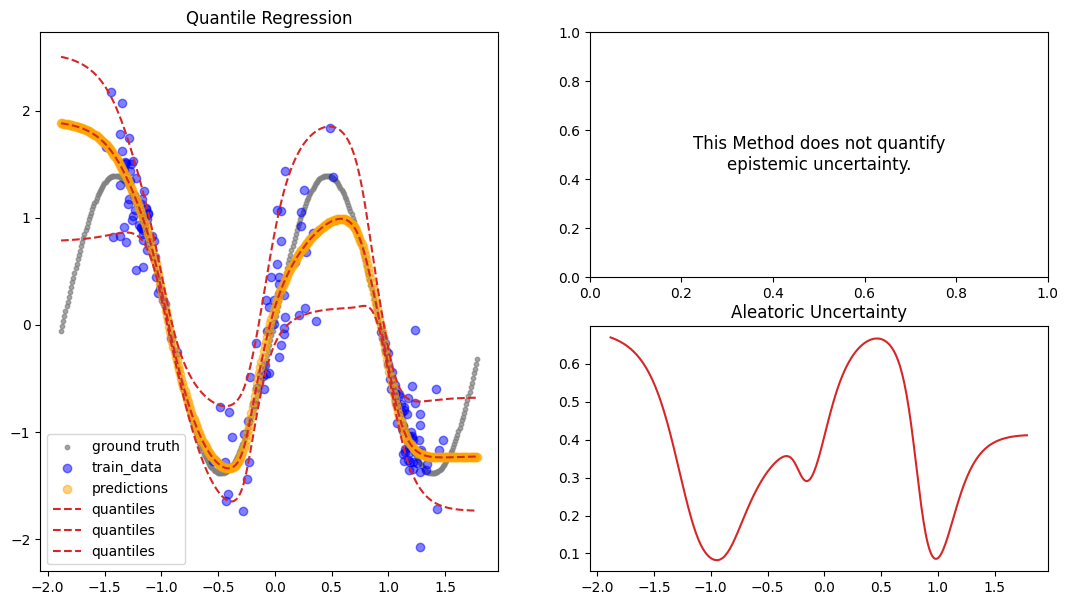

In [15]:
preds = qr_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    preds["pred"],
    pred_quantiles=np.stack(
        [
            preds["lower_quant"],
            preds["pred"].squeeze().cpu().numpy(),
            preds["upper_quant"],
        ],
        axis=-1,
    ),
    aleatoric=preds["aleatoric_uct"],
    title="Quantile Regression",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction.

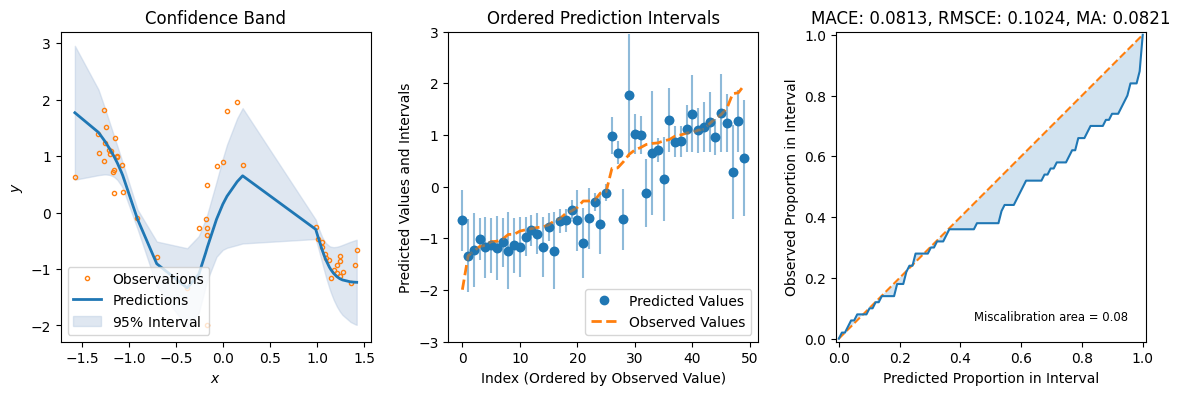

In [16]:
preds = qr_model.predict_step(X_test)
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)